In [14]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
from PhysicsDatasets import SHODatasetXV, DampedSHODatasetXV, DampedSHODatasetV2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import json
from matplotlib.colors import LogNorm
from utils import load_model
import utils
import os
from datetime import datetime
import yaml
import re
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Small masses, high k, undamped - no RoPE
See if model can generalize to high mass / low k

In [16]:
model_name = "discrete_mkb_mLo_kHi_beta0_noRoPE"
runs = [s for s in os.listdir(f"{base_dir}/{model_name}/")]
runs_time = [datetime.strptime(s,"%d%b%y_%H%M") for s in runs]
imax = max(enumerate(runs_time), key=lambda x: x[1])[0]
run = runs[imax]
model_dir = f"{base_dir}/{model_name}/{run}/"

config = utils.load_config(f"{model_dir}/config.yaml")
best_model = utils.load_model_v2(config,model_dir,ckpt='best')
all_models = [f for f in os.listdir(model_dir) if '.pt' in f and 'iter' in f]
iter_models = {}
iter_ckpts = []
for m in all_models:
    n_iter = int(re.search("iter(\d+)",m).group(1))
    iter_models[n_iter] = utils.load_model_v2(config,model_dir,name=m)
    iter_ckpts.append(n_iter)
iter_ckpts = sorted(iter_ckpts)    

cfg_dset = config['dataset_params']
seq_len = cfg_dset['seq_len']
dt = cfg_dset['dt']

number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M


In [19]:
masses = np.arange(1,11)
ks = np.arange(10,21)
betas = np.arange(5)

num_ctx = seq_len-1
num_trajectories_per = 100

output_best = np.zeros((num_ctx,len(masses),len(ks),len(betas)))
outputs_byIter = {n_iter:np.zeros((num_ctx,len(masses),len(ks),len(betas))) for n_iter in iter_ckpts}

progress_bar = tqdm(total=len(masses)*len(ks)*len(betas), desc="Processing")
for i1,m in enumerate(masses):
    for i2,k in enumerate(ks):
        for i3, beta in enumerate(betas):
            dset = DampedSHODatasetXV(num_trajectories=num_trajectories_per,
                                      masses=m,
                                      k=k,
                                      beta=beta,
                                      seq_len=seq_len,
                                      dt=dt)
            inpt, target = dset.xv[:,:-1,:], dset.xv[:,1:,:]
            with torch.no_grad():
                pred = model(inpt)
                mse = torch.mean(torch.sum((pred-target)**2,dim=-1),dim=0)
                output_best[:,i1,i2,i3] = mse
                for n_iter in iter_ckpts:
                    pred = iter_models[n_iter](inpt)
                    mse = torch.mean(torch.sum((pred-target)**2,dim=-1),dim=0)
                    outputs_byIter[n_iter][:,i1,i2,i3] = mse
            progress_bar.update(1)

Processing: 100%|██████████| 550/550 [08:13<00:00,  1.11it/s]

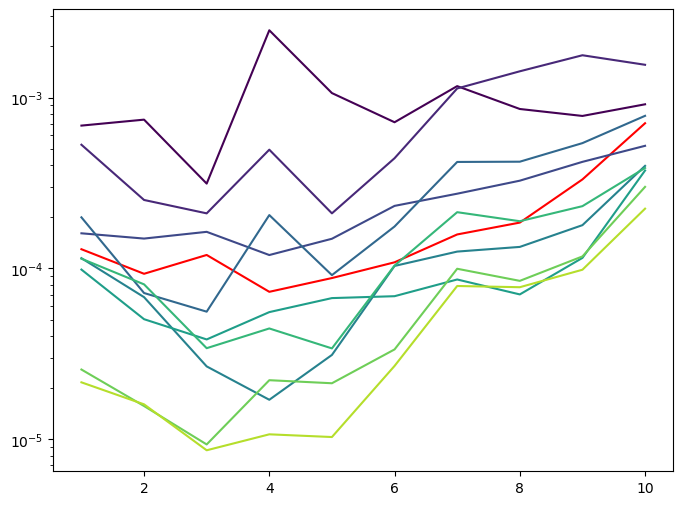

In [46]:
k_test = 18
beta_test = 0
n_ctx_test = 50
ik = list(ks).index(k_test)
ib = list(betas).index(beta_test)
cmap = plt.get_cmap('viridis')
colors = [cmap(i / (len(masses) - 1)) for i in range(len(masses))]

plt.figure(figsize=(8,6))
plt.plot(masses,output_best[n_ctx_test-1,:,ik,ib],color='red')
for ii,n_iter in enumerate(iter_ckpts[1:]):
    plt.plot(masses,outputs_byIter[n_iter][n_ctx_test-1,:,ik,ib],color=colors[ii])
plt.yscale('log')

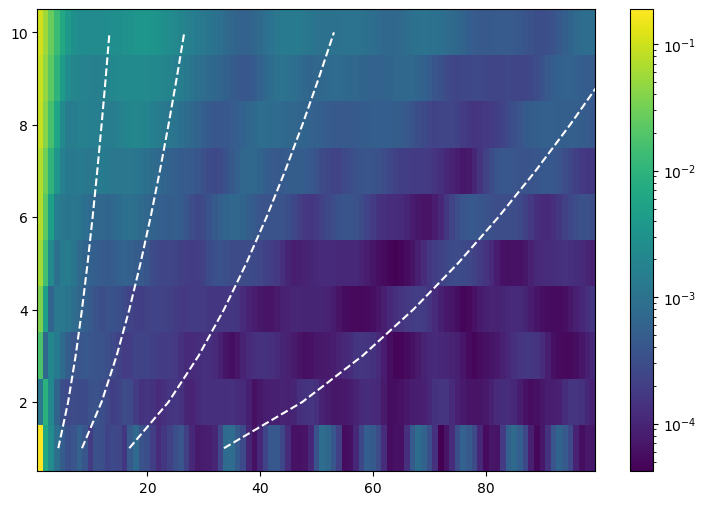

In [63]:
context_sizes = np.arange(1,100)
dm = masses[1]-masses[0]
dc = context_sizes[1]-context_sizes[0]

k_test = 14
beta_test = 0
n_ctx_test = 50
ik = list(ks).index(k_test)
ib = list(betas).index(beta_test)

fig,ax = plt.subplots(figsize=(9, 6))
X, Y = np.meshgrid(context_sizes, masses)
Z = output_best[:,:,ik,ib]
heatmap = plt.imshow(Z.T, extent=[context_sizes[0]-0.5*dc, context_sizes[-1]+0.5*dc,
                                  masses[0]-0.5*dm, masses[-1]+0.5*dm],
                     origin='lower', cmap='viridis', aspect='auto',norm=LogNorm(vmin=Z.min(),vmax=Z.max()))
Ts = (2*np.pi/np.sqrt(k_test/masses))/dt
mults = [0.25,0.5,1,2]
for mult in mults:
    plt.plot(mult*Ts,masses,color='white',linestyle='--')
plt.xlim([context_sizes[0]-0.5*dc, context_sizes[-1]+0.5*dc])
plt.colorbar()

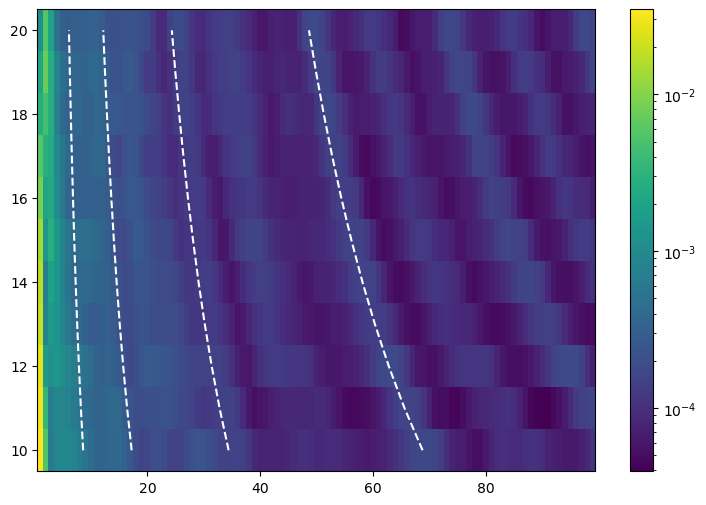

In [66]:
context_sizes = np.arange(1,100)
dk = ks[1]-ks[0]
dc = context_sizes[1]-context_sizes[0]

m_test = 3
beta_test = 0
n_ctx_test = 50
im = list(masses).index(m_test)
ib = list(betas).index(beta_test)

fig,ax = plt.subplots(figsize=(9, 6))
X, Y = np.meshgrid(context_sizes, masses)
Z = output_best[:,im,:,ib]
heatmap = plt.imshow(Z.T, extent=[context_sizes[0]-0.5*dc, context_sizes[-1]+0.5*dc,
                                  ks[0]-0.5*dk, ks[-1]+0.5*dk],
                     origin='lower', cmap='viridis', aspect='auto',norm=LogNorm(vmin=Z.min(),vmax=Z.max()))
Ts = (2*np.pi/np.sqrt(ks/m_test))/dt
mults = [0.25,0.5,1,2]
for mult in mults:
    plt.plot(mult*Ts,ks,color='white',linestyle='--')
plt.xlim([context_sizes[0]-0.5*dc, context_sizes[-1]+0.5*dc])
plt.colorbar()

In [6]:
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation, PillowWriter

dm = masses[1]-masses[0]
dk = ks[1]-ks[0]

fig,ax = plt.subplots(figsize=(8, 6))
X, Y = np.meshgrid(masses, ks)
Z = output_best[0]
heatmap = plt.imshow(Z.T, extent=[masses[0]-0.5*dm, masses[-1]+0.5*dm, ks[0]-0.5*dk, ks[-1]+0.5*dk],
                     origin='lower', cmap='viridis', aspect='auto',norm=LogNorm(vmin=Z.min(),vmax=Z.max()))
# Add a color bar
cbar = plt.colorbar(heatmap)
cbar.set_label('Mean MSE over 100 inits',fontsize=16)
# Add labels and title
plt.xlabel('Mass',fontsize=16)
plt.ylabel('Spring Constant',fontsize=16)
plt.title(f"$\\beta = {beta}$",fontsize=16)

tx_context = plt.text(7.2,19.5,"Context = 1",rotation=0,color='white',fontsize=16)

# Update function for animation
def update(frame):
    heatmap.set_data(output[frame].T)  # Update the image data
    tx_context.set_text(f"Context = {frame+1}")
    return [heatmap]

# Create the animation
ani = FuncAnimation(fig, update, frames=output.shape[0], interval=250, blit=True)
# Save the animation as a GIF
output_filename = f"animation_beta{beta}.gif"
ani.save(output_filename, writer=PillowWriter(fps=3))
# Close the figure after saving
plt.close(fig)

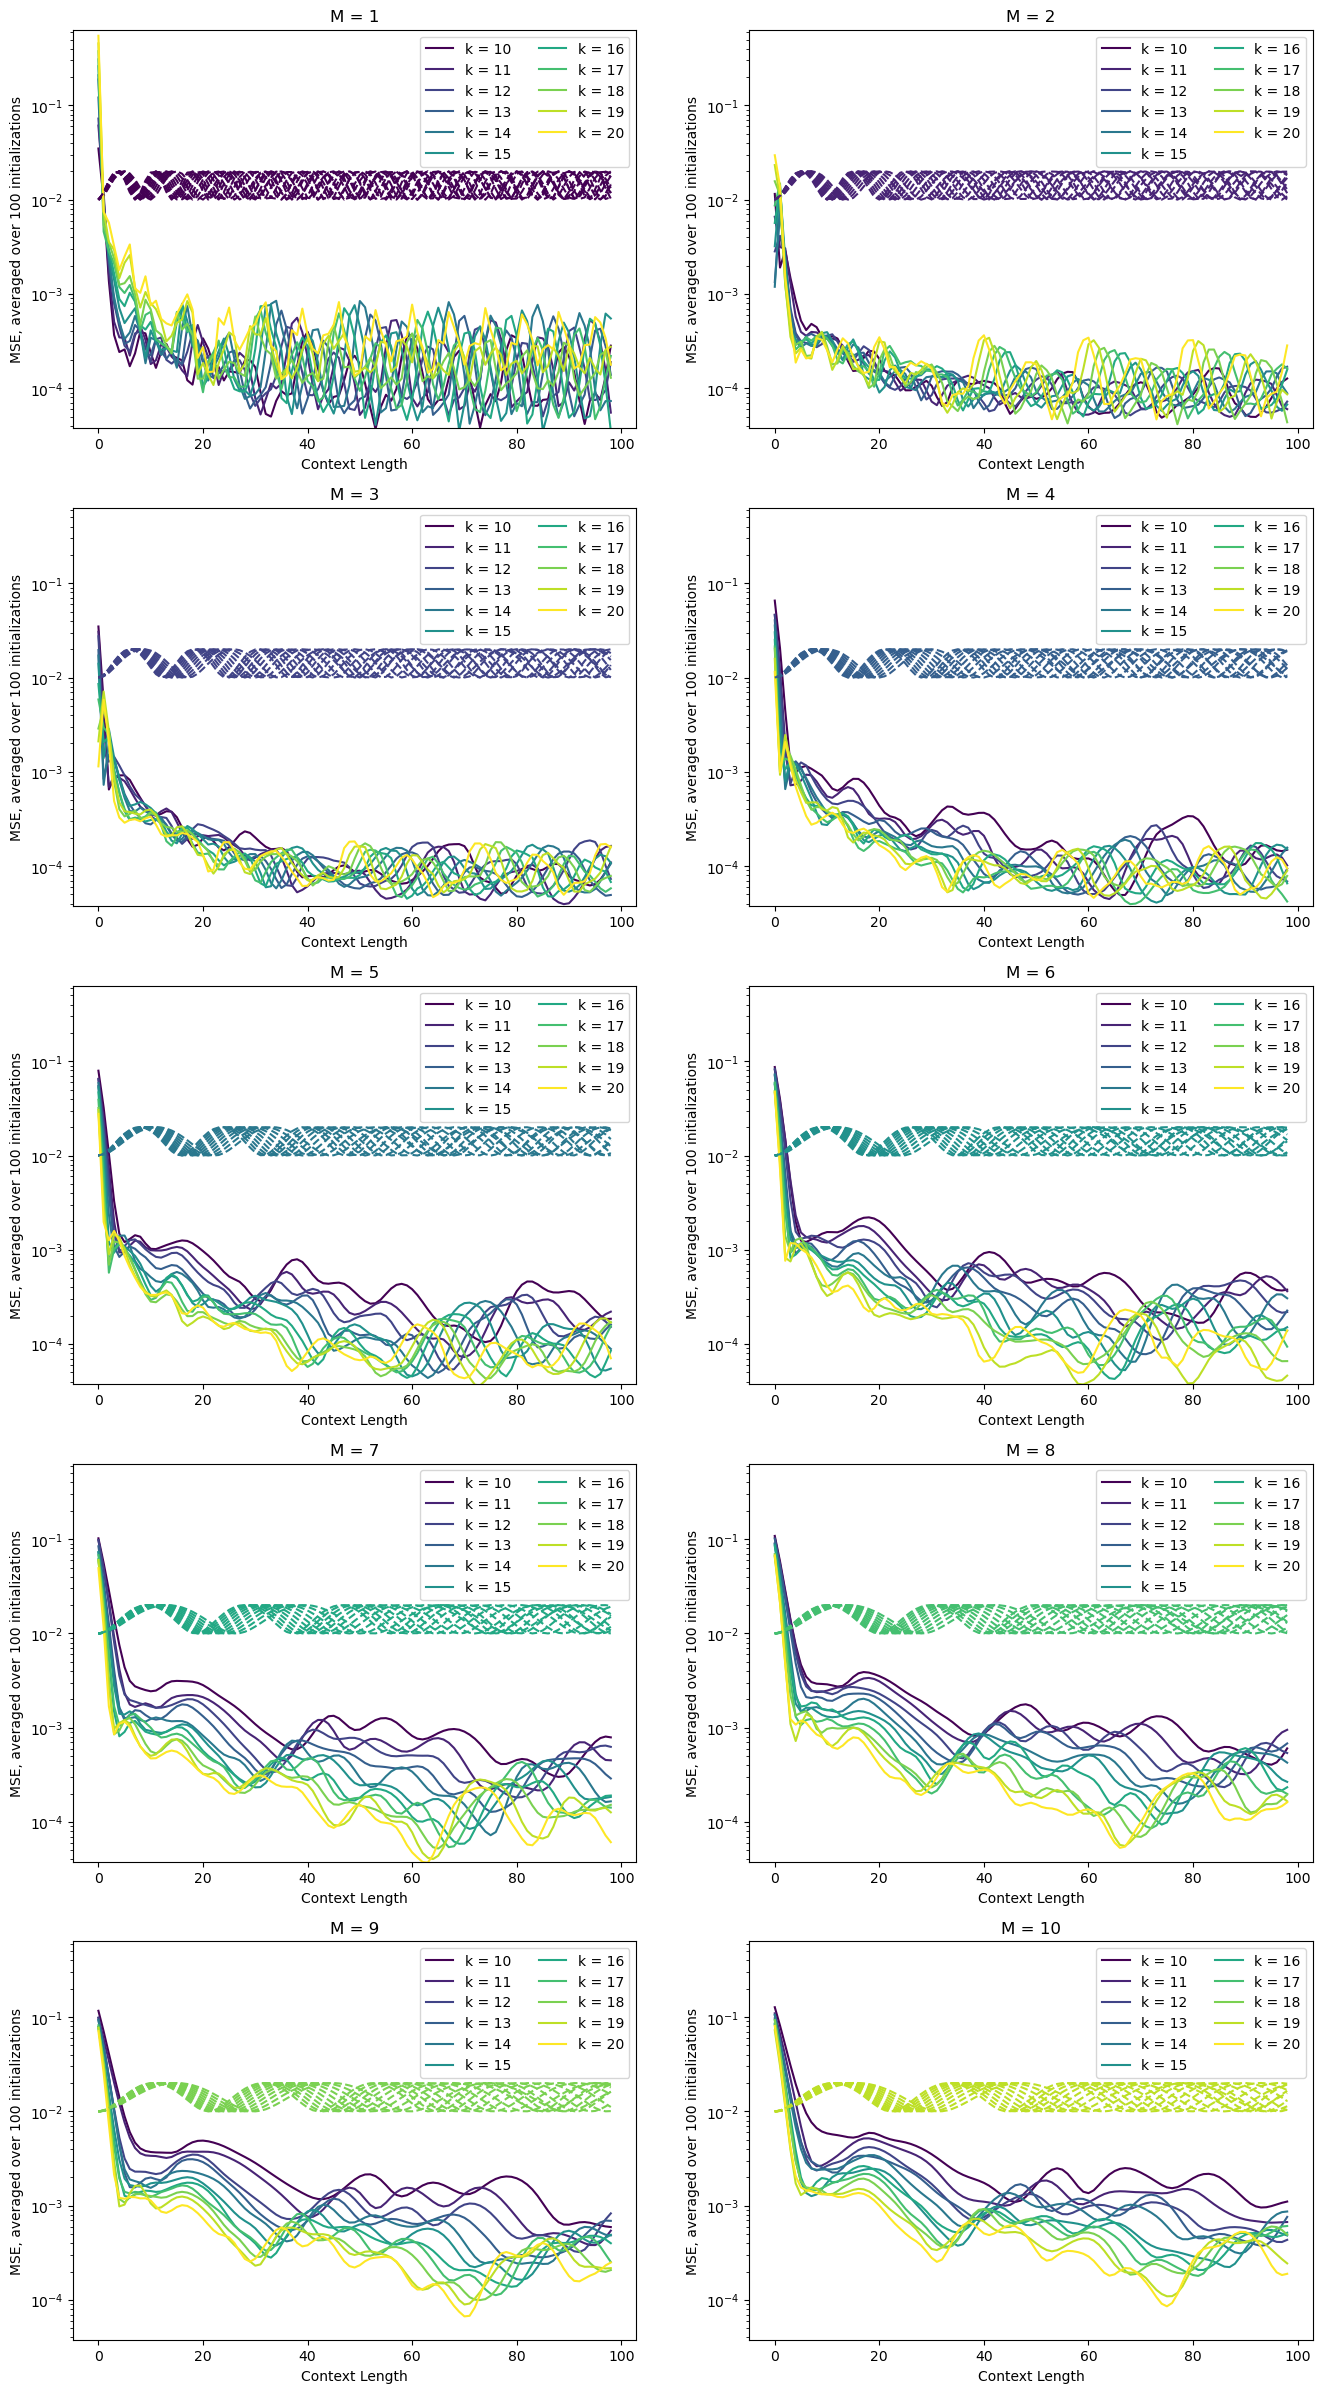

In [31]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i / (len(ks) - 1)) for i in range(len(ks))]

fig,axes = plt.subplots(len(masses)//2 + len(masses)%2,2,figsize=(8*2,6*(len(masses)//2)))
for i in range(len(masses)):
    plt.sca(axes.flatten()[i])
    title = f"M = {masses[i]}"
    for j in range(len(ks)):
        series = output_best[:,i,j,ib]
        plt.plot(np.arange(len(series)),series,label=f"k = {ks[j]}",color=colors[j])
        w = np.sqrt(ks[j]/masses[i])
        time = dt*np.arange(len(series))
        plt.plot(np.arange(len(series)),1e-2+(0.1*np.sin(w*time))**2,color=colors[i],linestyle='--')
             
    plt.ylim([output.min(),output.max()])
    plt.yscale('log')
    plt.legend(loc='upper right',ncol=2)
    plt.title(title)
    plt.xlabel("Context Length")
    plt.ylabel("MSE, averaged over 100 initializations")

# All masses, undamped, low k
See if model can generalize to high mass / low k

In [67]:
model_name = "discrete_mkb_mAll_kLo_beta0_noRoPE"
runs = [s for s in os.listdir(f"{base_dir}/{model_name}/")]
runs_time = [datetime.strptime(s,"%d%b%y_%H%M") for s in runs]
imax = max(enumerate(runs_time), key=lambda x: x[1])[0]
run = runs[imax]
model_dir = f"{base_dir}/{model_name}/{run}/"

config = utils.load_config(f"{model_dir}/config.yaml")
best_model = utils.load_model_v2(config,model_dir,ckpt='best')
all_models = [f for f in os.listdir(model_dir) if '.pt' in f and 'iter' in f]
iter_models = {}
iter_ckpts = []
for m in all_models:
    n_iter = int(re.search("iter(\d+)",m).group(1))
    iter_models[n_iter] = utils.load_model_v2(config,model_dir,name=m)
    iter_ckpts.append(n_iter)
iter_ckpts = sorted(iter_ckpts)    

cfg_dset = config['dataset_params']
seq_len = cfg_dset['seq_len']
dt = cfg_dset['dt']

number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M
number of parameters: 0.05M


In [68]:
masses = np.arange(1,11)
ks = np.arange(10,21)
betas = np.array([0])

num_ctx = seq_len-1
num_trajectories_per = 100

output_best = np.zeros((num_ctx,len(masses),len(ks),len(betas)))
outputs_byIter = {n_iter:np.zeros((num_ctx,len(masses),len(ks),len(betas))) for n_iter in iter_ckpts}

progress_bar = tqdm(total=len(masses)*len(ks)*len(betas), desc="Processing")
for i1,m in enumerate(masses):
    for i2,k in enumerate(ks):
        for i3, beta in enumerate(betas):
            dset = DampedSHODatasetXV(num_trajectories=num_trajectories_per,
                                      masses=m,
                                      k=k,
                                      beta=beta,
                                      seq_len=seq_len,
                                      dt=dt)
            inpt, target = dset.xv[:,:-1,:], dset.xv[:,1:,:]
            with torch.no_grad():
                pred = model(inpt)
                mse = torch.mean(torch.sum((pred-target)**2,dim=-1),dim=0)
                output_best[:,i1,i2,i3] = mse
                for n_iter in iter_ckpts:
                    pred = iter_models[n_iter](inpt)
                    mse = torch.mean(torch.sum((pred-target)**2,dim=-1),dim=0)
                    outputs_byIter[n_iter][:,i1,i2,i3] = mse
            progress_bar.update(1)


Processing: 100%|██████████| 550/550 [1:22:26<00:00,  8.99s/it]

Processing: 100%|██████████| 110/110 [01:46<00:00,  1.04it/s]

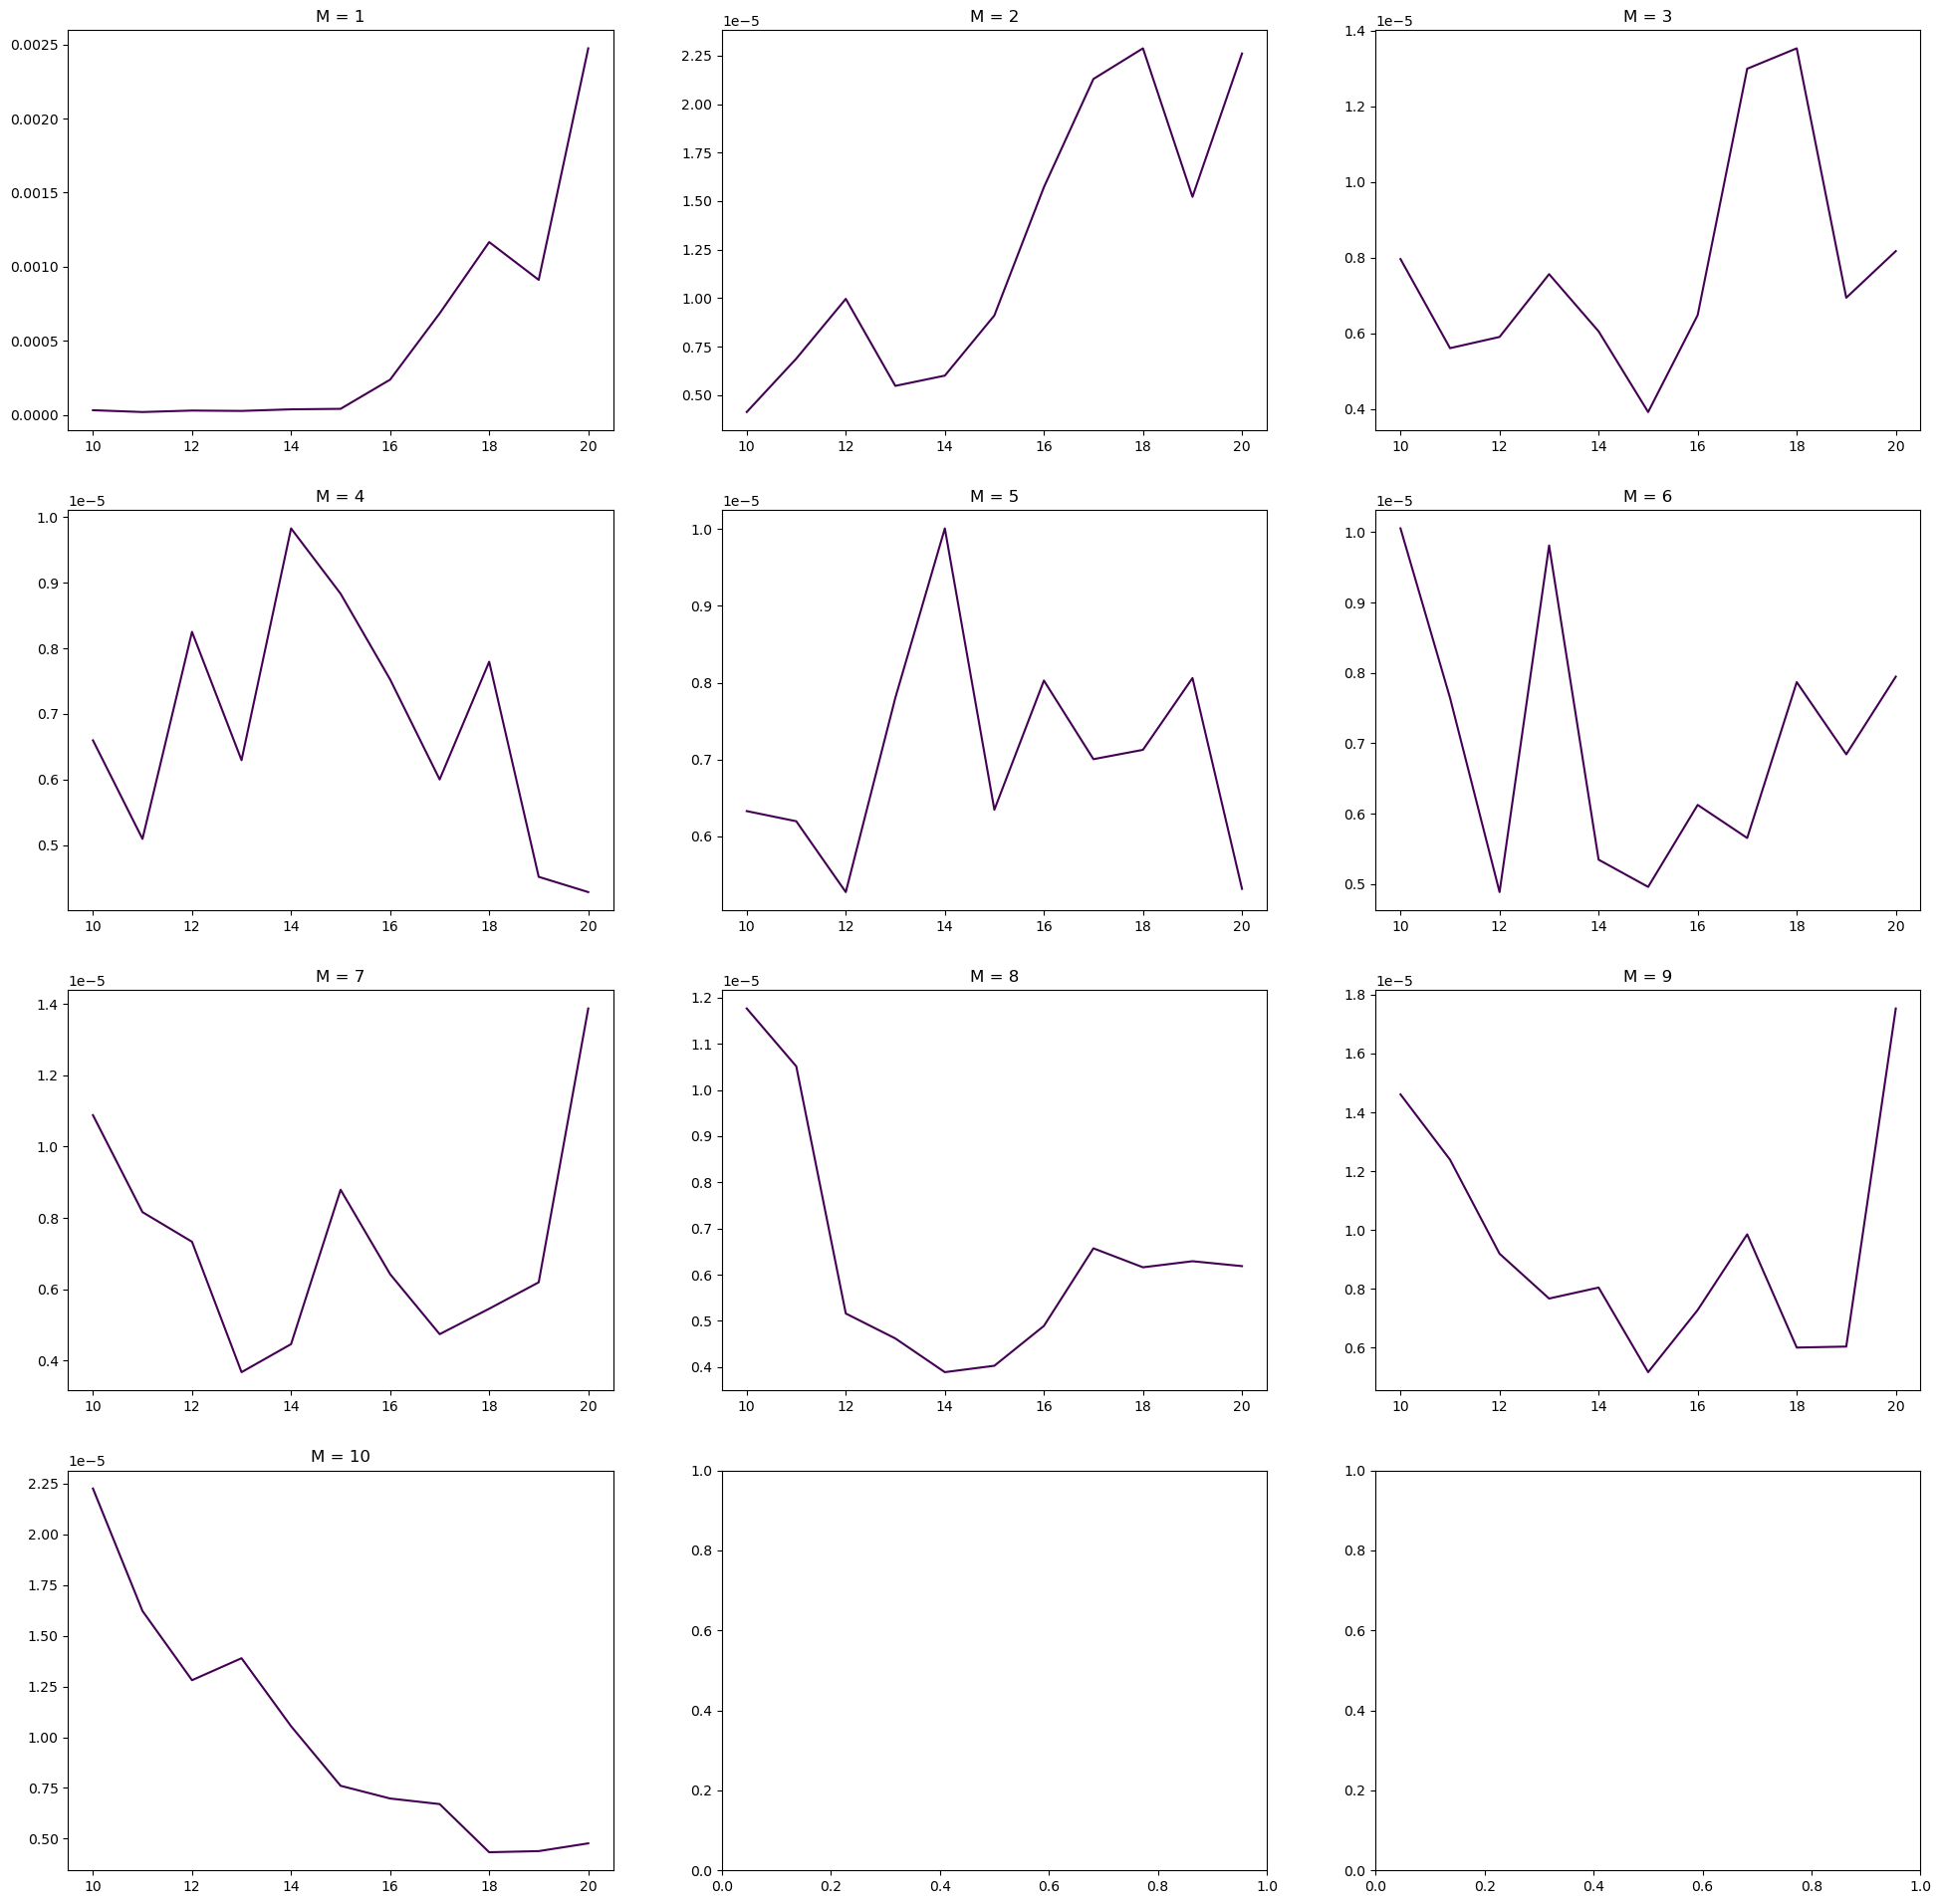

In [80]:
nrow = 4
ncol = len(masses)//4 + 1*int(len(masses)%4 > 0)
fig,axes = plt.subplots(4,ncol,figsize=(ncol*8,nrow*6))
n_ctx_test = 50

for i,m_test in enumerate(masses):
    plt.sca(axes.flatten()[i])
    beta_test = 0
    n_ctx_test = 50
    im = list(masses).index(m_test)
    ib = list(betas).index(beta_test)
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / (len(masses) - 1)) for i in range(len(masses))]

    #plt.plot(ks,output_best[n_ctx_test-1,im,:,ib],color='red')
    for ii,n_iter in enumerate(iter_ckpts[-1:]):
        plt.plot(ks,outputs_byIter[n_iter][n_ctx_test-1,im,:,ib],color=colors[ii])
    #plt.yscale('log')
    plt.title(f"M = {m_test}")

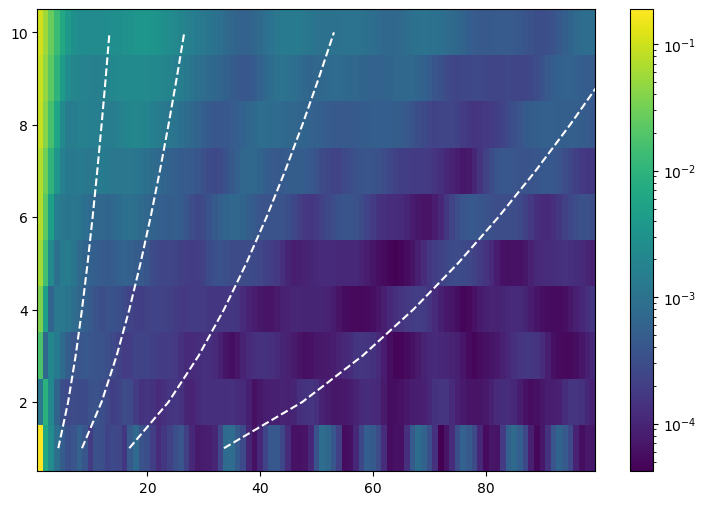

In [63]:
context_sizes = np.arange(1,100)
dm = masses[1]-masses[0]
dc = context_sizes[1]-context_sizes[0]

k_test = 14
beta_test = 0
n_ctx_test = 50
ik = list(ks).index(k_test)
ib = list(betas).index(beta_test)

fig,ax = plt.subplots(figsize=(9, 6))
X, Y = np.meshgrid(context_sizes, masses)
Z = output_best[:,:,ik,ib]
heatmap = plt.imshow(Z.T, extent=[context_sizes[0]-0.5*dc, context_sizes[-1]+0.5*dc,
                                  masses[0]-0.5*dm, masses[-1]+0.5*dm],
                     origin='lower', cmap='viridis', aspect='auto',norm=LogNorm(vmin=Z.min(),vmax=Z.max()))
Ts = (2*np.pi/np.sqrt(k_test/masses))/dt
mults = [0.25,0.5,1,2]
for mult in mults:
    plt.plot(mult*Ts,masses,color='white',linestyle='--')
plt.xlim([context_sizes[0]-0.5*dc, context_sizes[-1]+0.5*dc])
plt.colorbar()

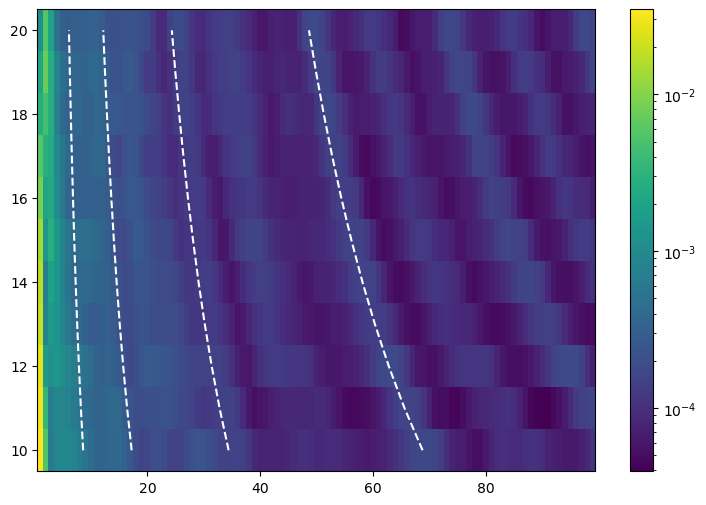

In [66]:
context_sizes = np.arange(1,100)
dk = ks[1]-ks[0]
dc = context_sizes[1]-context_sizes[0]

m_test = 3
beta_test = 0
n_ctx_test = 50
im = list(masses).index(m_test)
ib = list(betas).index(beta_test)

fig,ax = plt.subplots(figsize=(9, 6))
X, Y = np.meshgrid(context_sizes, masses)
Z = output_best[:,im,:,ib]
heatmap = plt.imshow(Z.T, extent=[context_sizes[0]-0.5*dc, context_sizes[-1]+0.5*dc,
                                  ks[0]-0.5*dk, ks[-1]+0.5*dk],
                     origin='lower', cmap='viridis', aspect='auto',norm=LogNorm(vmin=Z.min(),vmax=Z.max()))
Ts = (2*np.pi/np.sqrt(ks/m_test))/dt
mults = [0.25,0.5,1,2]
for mult in mults:
    plt.plot(mult*Ts,ks,color='white',linestyle='--')
plt.xlim([context_sizes[0]-0.5*dc, context_sizes[-1]+0.5*dc])
plt.colorbar()

In [6]:
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation, PillowWriter

dm = masses[1]-masses[0]
dk = ks[1]-ks[0]

fig,ax = plt.subplots(figsize=(8, 6))
X, Y = np.meshgrid(masses, ks)
Z = output_best[0]
heatmap = plt.imshow(Z.T, extent=[masses[0]-0.5*dm, masses[-1]+0.5*dm, ks[0]-0.5*dk, ks[-1]+0.5*dk],
                     origin='lower', cmap='viridis', aspect='auto',norm=LogNorm(vmin=Z.min(),vmax=Z.max()))
# Add a color bar
cbar = plt.colorbar(heatmap)
cbar.set_label('Mean MSE over 100 inits',fontsize=16)
# Add labels and title
plt.xlabel('Mass',fontsize=16)
plt.ylabel('Spring Constant',fontsize=16)
plt.title(f"$\\beta = {beta}$",fontsize=16)

tx_context = plt.text(7.2,19.5,"Context = 1",rotation=0,color='white',fontsize=16)

# Update function for animation
def update(frame):
    heatmap.set_data(output[frame].T)  # Update the image data
    tx_context.set_text(f"Context = {frame+1}")
    return [heatmap]

# Create the animation
ani = FuncAnimation(fig, update, frames=output.shape[0], interval=250, blit=True)
# Save the animation as a GIF
output_filename = f"animation_beta{beta}.gif"
ani.save(output_filename, writer=PillowWriter(fps=3))
# Close the figure after saving
plt.close(fig)

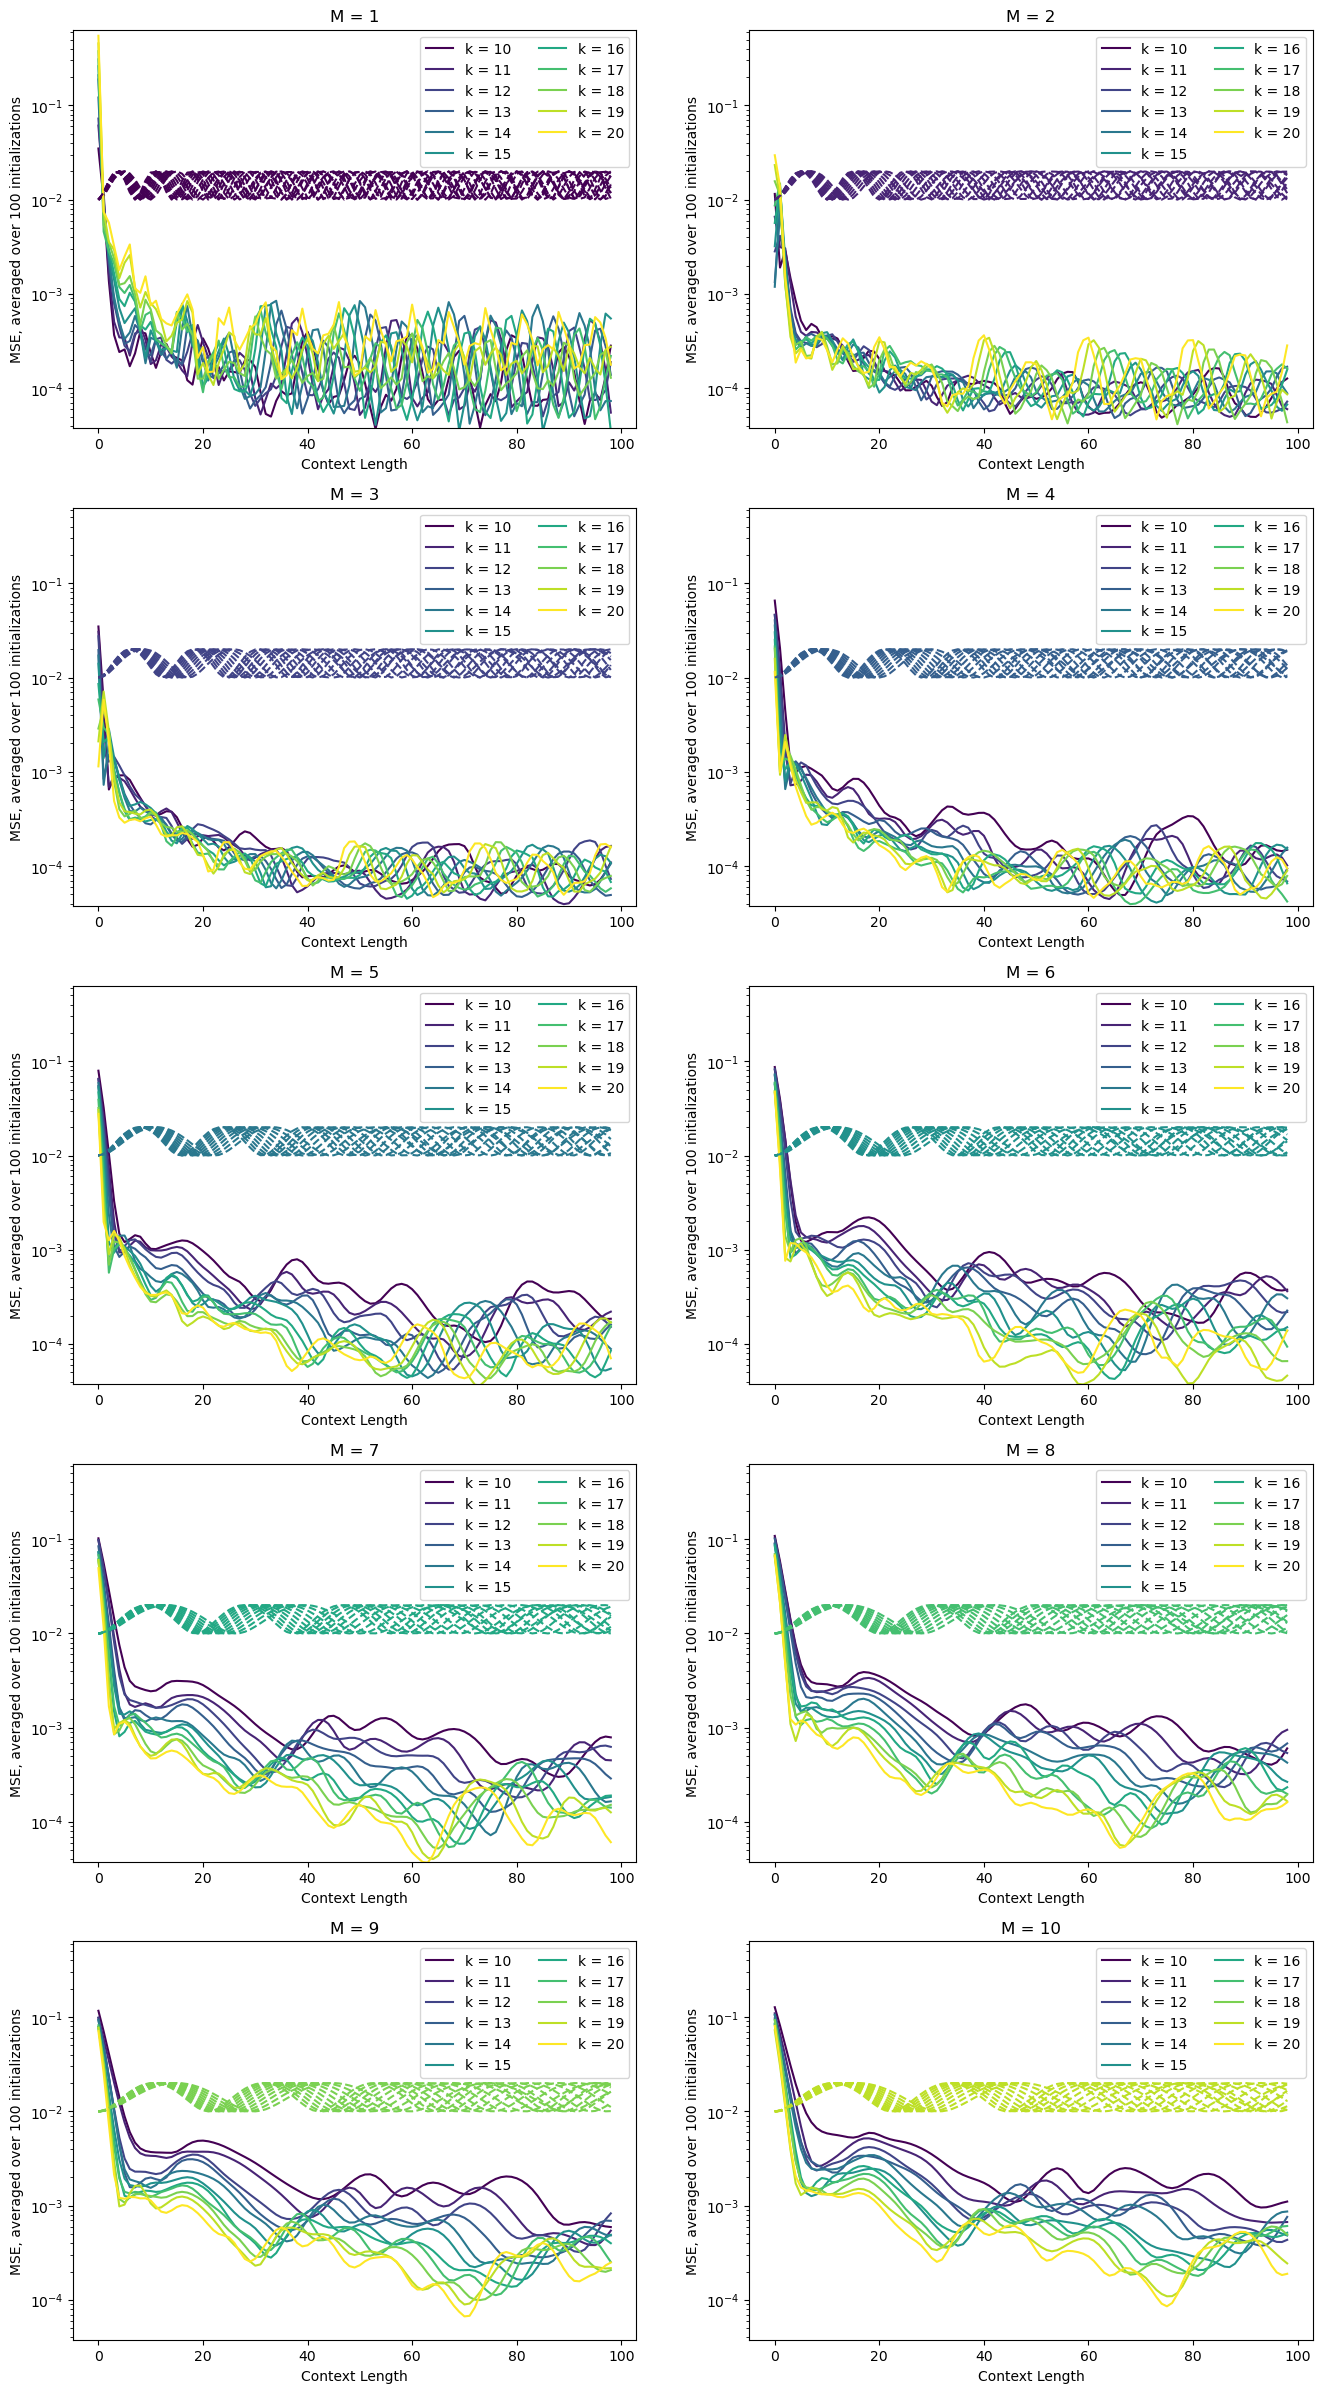

In [31]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i / (len(ks) - 1)) for i in range(len(ks))]

fig,axes = plt.subplots(len(masses)//2 + len(masses)%2,2,figsize=(8*2,6*(len(masses)//2)))
for i in range(len(masses)):
    plt.sca(axes.flatten()[i])
    title = f"M = {masses[i]}"
    for j in range(len(ks)):
        series = output_best[:,i,j,ib]
        plt.plot(np.arange(len(series)),series,label=f"k = {ks[j]}",color=colors[j])
        w = np.sqrt(ks[j]/masses[i])
        time = dt*np.arange(len(series))
        plt.plot(np.arange(len(series)),1e-2+(0.1*np.sin(w*time))**2,color=colors[i],linestyle='--')
             
    plt.ylim([output.min(),output.max()])
    plt.yscale('log')
    plt.legend(loc='upper right',ncol=2)
    plt.title(title)
    plt.xlabel("Context Length")
    plt.ylabel("MSE, averaged over 100 initializations")